In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from IPython.display import display
import matplotlib.patches as patches

import torch
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm

## Test and train data

In [3]:
train_data_dir = '/kaggle/input/airbus-ship-detection/train_v2'
test_data_dir = '/kaggle/input/airbus-ship-detection/test_v2'
mask_dir = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'
sample_submission = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')

train_data = os.listdir(train_data_dir)
test_data = os.listdir(test_data_dir)

print(train_data[:6])
print(test_data[:6])
print(sample_submission.head())

['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg', '7c8d78c3f.jpg', '290f37d66.jpg', '6a91a5706.jpg']
['4291f3a66.jpg', 'b0808caaf.jpg', '9f582d5ce.jpg', '916ae8dd3.jpg', '6fa533973.jpg', 'e0cf877a8.jpg']
         ImageId EncodedPixels
0  00002bd58.jpg           1 2
1  00015efb6.jpg           1 2
2  00023d5fc.jpg           1 2
3  000367c13.jpg           1 2
4  0008ca6e9.jpg           1 2


In [4]:
mask = pd.read_csv(mask_dir)
mask.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
null_ship = mask.EncodedPixels.isnull().sum()
not_null_ship = mask.EncodedPixels.notnull().sum()
mask["ships"] = mask.EncodedPixels.map(lambda x: 1 if not pd.isna(x) else 0)
print(null_ship)
print(not_null_ship)

150000
81723


## RLE Decoding and Mask Combination for Image Segmentation
The provided code segment performs RLE decoding and combines masks for image segmentation tasks. It also includes functions for displaying images with masks. Additionally it sets up transformations for images and loads the dataset for further processing

<Figure size 1200x800 with 0 Axes>

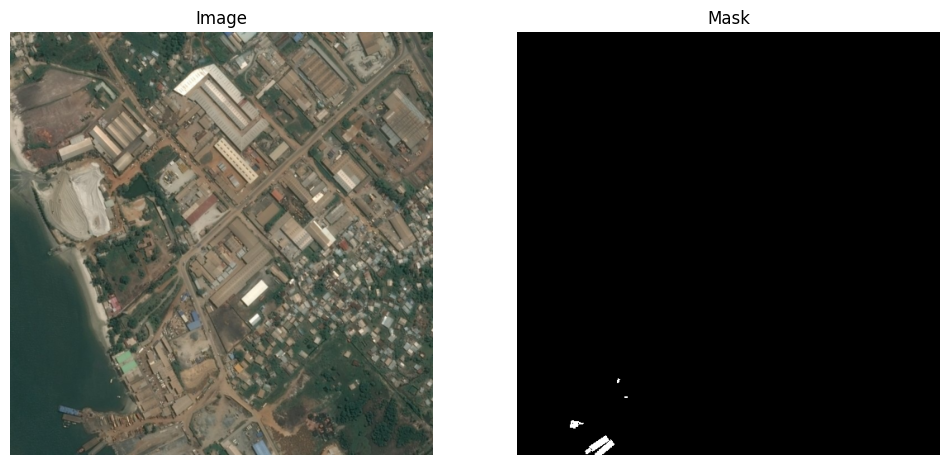

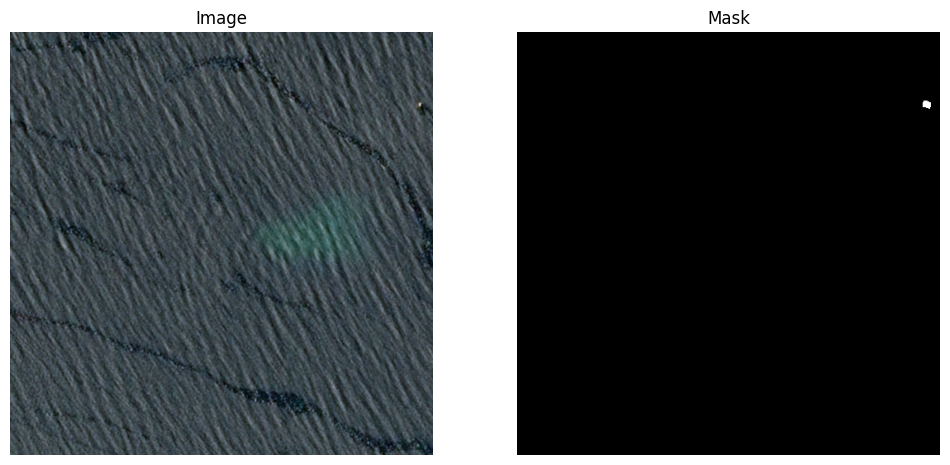

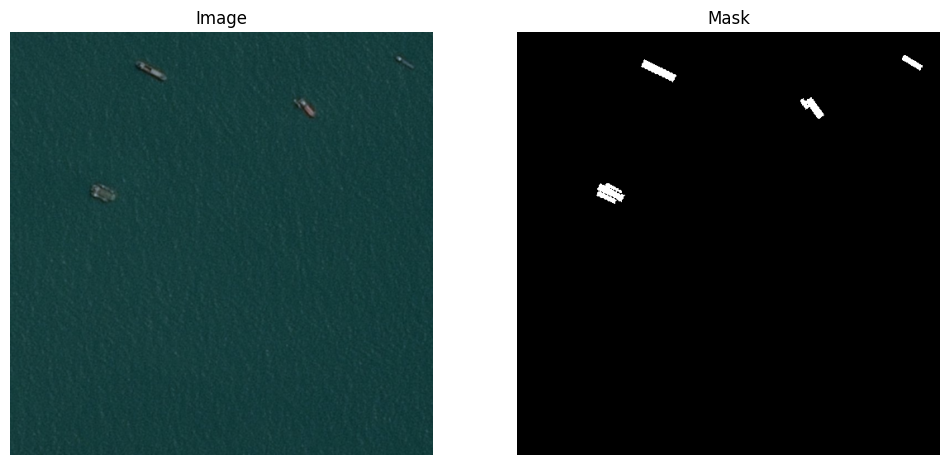

In [6]:
def decode_rle(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts = np.asarray(s[::2], dtype=int) - 1
    lengths = np.asarray(s[1::2], dtype=int)
    ends = starts + lengths
    decoded_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        decoded_mask[start:end] = 1
    return decoded_mask.reshape(shape)

def combine_masks(mask_data, shape=(768, 768)):
    combined_mask = np.zeros(shape, dtype=np.uint8)
    if not isinstance(mask_data, float):
        for m in mask_data:
            if isinstance(m, str):
                combined_mask |= decode_rle(m, shape)
    return Image.fromarray(combined_mask.T)

def display_image_with_mask(img_idx, mask, train_data_dir, transform=None):
    image_id = mask.loc[mask.EncodedPixels.notnull(), 'ImageId'].iloc[img_idx]
    mask_data = mask.query(f'ImageId == "{image_id}"').EncodedPixels.values
    image_path = os.path.join(train_data_dir, image_id)
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    mask_tensor = combine_masks(mask_data)
    mask_data = transform(mask_tensor)
    mask_data = (mask_data > 0).float()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_data[0], cmap='gray')
    plt.axis('off')
    plt.title('Mask')

    plt.show()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

plt.figure(figsize=(12, 8))
display_image_with_mask(7, mask, train_data_dir, transform=transform)
display_image_with_mask(20, mask, train_data_dir, transform=transform)
display_image_with_mask(30, mask, train_data_dir, transform=transform)

##  U-Net neural network architecture for semantic segmentation tasks

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

class DConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        for feature in features:
            self.downs.append(DConv(input_channels, feature))  
            input_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2,
                                   feature,
                                   kernel_size=2,
                                   stride=2))
            self.ups.append(DConv(feature * 2, feature))

        self.bottleneck = DConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1) 

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])  
            concat_skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip_connection)

        return self.final_conv(x)

This code gets images and their corresponding masks ready for training a model. It checks if there are ships in the images and creates a mask accordingly. Then, it resizes both the images and masks to make them easier to work with. The resized data is organized into batches for the model to learn from. The dataset is divided into two parts: one for training the model and the other for testing its accuracy. This code sets everything up so the model can learn to recognize ships in pictures.

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

batch_size = 28

image_list = []
mask_list = []
for idx in range(len(mask)):
    image_name = mask.loc[mask['ships'] == 1, 'ImageId'].iloc[idx]
    image_path = os.path.join(train_data_dir, image_name)
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)
    image_list.append(image_tensor)

    mask_rle = mask.loc[mask['ImageId'] == image_name, 'EncodedPixels'].values
    if len(mask_rle) > 0:
        mask_rle_str = mask_rle[0] if isinstance(mask_rle[0], str) else ''
        mask_data = decode_rle(mask_rle_str)
        mask_data_pil = Image.fromarray(mask_data)
        mask_tensor = mask_transform(mask_data_pil)
        mask_tensor = (mask_tensor > 0).float()
        mask_list.append(mask_tensor)

image_tensor = torch.stack(image_list)
mask_tensor = torch.stack(mask_list)

dataset = TensorDataset(image_tensor, mask_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


The code creates a UNet model for image tasks, using GPU or CPU. It sets up training settings like learning rate and epochs, and defines the loss function and optimizer. The training loop handles data processing and model updates. Functions for saving progress and checking accuracy are included. During training, the model's performance is periodically saved and checked.

In [9]:
if torch.cuda.is_available():
    dvc = 'cuda' 
else:
    dvc = 'cpu'

model = Unet(input_channels=3, output_channels=1).to(dvc)

learning_rate = 1e-6
num_epochs = 5

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loop = tqdm(train_data_loader)

    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(dvc)
        target = target.float().to(dvc)
        predictions = model(data)
        loss = loss_fn(predictions, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    print("Saving checkpoint")
    torch.save(checkpoint, "my_checkpoint.pth.tar")

    # Evaluate accuracy on test data
    model.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0

    with torch.no_grad():
        for x, y in test_data_loader:
            x = x.to(dvc)
            y = y.to(dvc)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f'Epoch {epoch+1}/{num_epochs}: Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}')
    print(f'Epoch {epoch+1}/{num_epochs}: Dice score: {dice_score/len(test_data_loader)}')
    model.train()

100%|██████████| 58/58 [1:28:52<00:00, 91.94s/it, loss=0.53] 


Saving checkpoint
Epoch 1/5: Got 24564061/26214400 with accuracy 93.70
Epoch 1/5: Dice score: 0.0052848150953650475


100%|██████████| 58/58 [1:30:27<00:00, 93.58s/it, loss=0.524] 


Saving checkpoint
Epoch 2/5: Got 24790955/26214400 with accuracy 94.57
Epoch 2/5: Dice score: 0.005752473138272762


100%|██████████| 58/58 [1:30:00<00:00, 93.10s/it, loss=0.519]


Saving checkpoint
Epoch 3/5: Got 24821273/26214400 with accuracy 94.69
Epoch 3/5: Dice score: 0.005412102211266756


 95%|█████████▍| 55/58 [1:27:21<04:39, 93.02s/it, loss=0.5]   

Epoch 4/5: Got 25071395/26214400 with accuracy 95.64
Epoch 4/5: Dice score: 0.005716407205909491


100%|██████████| 58/58 [1:29:01<00:00, 92.09s/it, loss=0.506]


Saving checkpoint
Epoch 5/5: Got 25219172/26214400 with accuracy 96.20
Epoch 5/5: Dice score: 0.005607322324067354
